# QG8 demo - Writing and reading a quantum graph in Python

Author: S. Whitlock (whitlock@unistra.fr)
Version 1.0: 18 July 2021 

The latest version of this [IPython notebook] (http://ipython.org/ipython-doc/dev/interactive/htmlnotebook.html) is available at https://github.com/aQCess/QG8-Python.

## Introduction

QG8 is a lightweight data format for storing and exchanging numerical tensor data and data flow graphs in a binary format. It was created as way to store quantum models and data in a single file, including quantum gate and quantum circuit specifications, control pulse definitions, time independent and time-dependent model Hamiltonians, device characteristics, calibration data and noise models, user defined control flow instructions and simulation or measurement results. 

In this notebook we will build a quantum graph representing a quantum gate protocol with time-dependent control pulses. The graph can be written to a QG8 file and read again. This allows for defining problem specifications in one language or one one system and executing the graph on another. In this example we show how a QG8 graph can be integrated with Python and the QuTip package in order to simulate the gate.

For more information see the QG8 project GitHub page at https://github.com/aQCess/QG8.

### Installation

To use QG8 just copy the qg8 folder to the python path or put it in your project directory. 

> *For this demonstration we additionally make use of the Numpy and QuTip packages. To install QuTiP, download the latest release from https://qutip.org.*

> *For an introduction to QuTip notebooks we recommend the tutorials page of the QuTip project https://qutip.org/tutorials.html and the guide to basic operations https://qutip.org/docs/latest/guide/guide-basics.html.*

### Working principle

The core idea of the QG8 data format and graph based representations of quantum systems in general is to store quantum data and operations and as nodes of a data flow graph. Each node accepts information from its input nodes and edges represent the flow of information through the graph. The advantage of this approach is that it allows to store all the data required for a computation as well as the instructions on how to perform operations on the data in a single object which can then easily be exchanged between different systems. 

In QG8 we classify nodes according to two main types: (i) *tensor nodes* which contain data. These act as input nodes or intermediate placeholder nodes for the graph. (ii) *op nodes* which do not contain data but indicate which operations should be performed on the data. In QG8 we do not provide an exhaustive set of possible operations, rather we allow the user to write their own operations which will be called by the graph when executed.

## Getting started with a QG8 graph: `QuantumGraph()`

Lets first include the necessary modules.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import qg8

The starting point for our demonstration is the `QuantumGraph` class. This is the basic object which stores all the information for the quantum gate as a list of nodes.

We can create an empty `QuantumGraph` instance by calling `QuantumGraph()`.

In [2]:
mygraph = qg8.QuantumGraph()

A quantum graph is a container for QG8 nodes. For the moment we can see that it is empty.

In [3]:
mygraph.nodes

[]

### QG8 node: `QG8Node`

Graph nodes are instances of the general `QG8Node` class (which in turn inherits from `qg8_chunk` in the core qg8 implementation). QG8 nodes can be either: (i) *tensor nodes*, containing input or placeholders for output data which can be represented as a scalar, vector, matrix or higher order tensors of numerical values; or (ii) *op nodes*, that describe operations that should be done on the tensors when the graph is run. 

The node types that are implemented in this demo can be found in the `type_registry` dictionary. More custom node types can be defined and added in the `qg8.ops` library.

In [4]:
qg8.node_types()

{'constant',
 'expectationvalue',
 'input',
 'join',
 'ket',
 'matmul',
 'observable',
 'operator',
 'solvequtip',
 'time',
 'track'}

As a simple example, lets create two generic `input` tensor nodes and fill them with data from a numpy array using the `QuantumGraph.input` method.

In [5]:
x = np.array([1., 2., 3., 4., 5.])
M = np.array([[0,0,1,1,0], [1,0,0,0,0], [1,0,1,0,0], [0,0,0,1,1], [1,0,0,0,1]]) 

vector = mygraph.input(x)
matrix = mygraph.input(M)

Here we have used the `np.array` method to construct a five element vector (a rank 1 tensor with shape [5]) and a 5x5 element matrix (a rank 2 tensor).

QG8 tensor data are efficiently stored in a sparse format as a list of indice arrays `(i,j...)` and values `re` and `im` corresponding to the real and imaginary parts of non-zero elements. 

> *If you want to store all elements of the tensor, including zeros, you can use the argument `packing='full'` when creating the node.* 

> *By default QG8 stores data in a format depending on the data type of the numpy array. If you want to specify a particular data type you can use the `dtype='name'` keyword argument when defining tensor nodes, where 'name' is a numerical type string accepted as input to the `numpy.dtype()` class.*


One can see what is inside the tensor by calling `node.indices()`, `node.values()` or the `node.full()` method

In [6]:
matrix.indices(), matrix.values()

([array([0, 0, 1, 2, 2, 3, 3, 4, 4], dtype=uint8),
  array([2, 3, 0, 0, 2, 3, 4, 0, 4], dtype=uint8)],
 array([1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))

In [7]:
matrix.full()

array([[0, 0, 1, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [1, 0, 0, 0, 1]])

We can now add a simple op node which performs a matrix product of two nodes. In this case the behavior is that of `numpy.matmul()`.

In [8]:
product = mygraph.matmul(matrix, vector)

The functions which are called to evaluate op nodes are defined in the `qg8.ops` library.  Each op function takes a `QG8Node` as an input and processes them by setting the `.output` attribute depending on their assigned input nodes (`vector` and `matrix` in this example). These functions are evaluated according to their topological order in the graph when `QuantumGraph.run()` is called.

> *While we have assigned the nodes `vector` and `matrix`, these are just a pointers to nodes in the graph. If you must remove a node from the graph one can use the `mygraph.remove(qg8_node)` method, but this will not remove dependencies of other nodes*.

Now our quantum graph should contain three nodes. 

> *Beware that running the above code several times results in adding several nodes to the graph.*



Before we save the graph we must also store the edges between graph nodes (i.e. indicating that `matrix` and `vector` are input nodes to `product`). This can be done by building an adjacency matrix for the graph. Adjacency matrices are not regular graph nodes and will be stored in the graph along with the nodes as "chunks".

In [9]:
A = mygraph.adjacency_matrix()
mygraph.chunks

[<QG8 tensor node:input, shape=(5,), length=5, itype=uint8, dtype=float64>,
 <QG8 tensor node:input, shape=(5, 5), length=9, itype=uint8, dtype=int64>,
 <QG8 op node:matmul>,
 <QG8 adjacency matrix:, shape=(3, 3), length=2>]

To save a graph to file, call `qg8.save('filename',graph)`

In [10]:
qg8.save('mygraph.qg8',mygraph);

It can be read in again as a new graph.

In [11]:
savedgraph = qg8.load('mygraph.qg8')
savedgraph.chunks

[<QG8 tensor node:input, shape=(5,), length=5, itype=uint8, dtype=float64>,
 <QG8 tensor node:input, shape=(5, 5), length=9, itype=uint8, dtype=int64>,
 <QG8 op node:matmul>,
 <QG8 adjacency matrix:, shape=(3, 3), length=2>]

We can now execute the graph by calling the `run` method and verify the result. By default the graph is computed up to the last node added to the graph.

In [12]:
result = qg8.run(savedgraph)

print(result)

all(result == np.matmul(M,x)) # verify result

[7. 1. 4. 9. 6.]


True

## Working example: iSWAP gate

We now show how to build a complete graph for simulating a quantum gate, including Hamiltonian terms, operators, observables and op nodes which connect them. 

For illustration we consider a two-qubit iSWAP gate for Rydberg atom qubits, which is a special case of the XY gate family described in M. Morgardo & S. Whitlock, AVS Quantum Sci. 3, 023501 (2021) (open access link: https://arxiv.org/abs/2011.03031). This specific gate protocol works by coupling the qubit states $0$ and $1$ to two auxiliary states called $S$ and $P$ and by exploiting two-body exchange interactions $SP \leftrightarrow PS$.

### Building the Hamiltonian

In [13]:
iSWAP = qg8.QuantumGraph()

To represent the Hamiltonian of the two-qubit system use a decomposition in terms of time-independent operators $\hat h_j$ and time-dependent coefficients $c_j(t)$
 
$$\hat H = \sum_j c_j(t) \hat h_j + h.c.$$

where $h.c.$ stands for Hermitian conjugate. 

> *With QG8 it is not necessary to save the Hermitian conjugate operators, since we can use the packing argument `packing="half-hermitian"`. The hermitian conjugate terms will then be automatically added in the solver.*

#### Operators

For this demonstration we define three operators describing the single particle couplings acting on both qubits and the two-particle exchange interaction operator:
\begin{align}
\hat h_1 &= |S\rangle\langle 1|\otimes \mathbb{1} + \mathbb{1}\otimes |S\rangle\langle 1|\\
\hat h_2 &= |P\rangle\langle 0|\otimes \mathbb{1} + \mathbb{1}\otimes |P\rangle\langle 0|\\
\hat h_3 &= |P S\rangle\langle S P|
\end{align}

where the subscripts indicate which qubit the operator is acting on, and $|\alpha \beta\rangle = |\alpha\rangle\otimes|\beta\rangle$ represents a two qubit state, $\otimes$ is the tensor product and $\mathbb{1}$ is the identity operator in the single qubit basis.

To generate these operators as Numpy arrays, lets start by defining a set of single qubit basis vectors and some helper functions which return matrices representing single qubit and two qubit operators in the two-qubit basis. *We can also save a little bit of space by expressing these and the corresponding operators as 8 bit integers.*

In [14]:
# single qubit basis vectors
zero = np.array([[1],[0],[0],[0]],dtype='uint8')
one = np.array([[0],[1],[0],[0]],dtype='uint8')
S = np.array([[0],[0],[1],[0]],dtype='uint8')
P = np.array([[0],[0],[0],[1]],dtype='uint8')

In [15]:
# Helper functions for constructing single qubit and two-qubit operators as Numpy matrices 
def O1(s1,s2,target=1):
    """
    Function which returns a general one-qubit operator |s1><s2| in a two-qubit basis.
    target : integer specifying the qubit that the operator is acting on
    """
    out = 1;
    for i in range(2):
        if i==target-1:
            out = np.kron(out, s1 @ np.conjugate(s2).T)
        else:
            out = np.kron(out, np.eye(len(s1)));
    return out.astype(s1.dtype)


def O2(s1,s2,s3,s4):
    """
    Function which returns a general two-qubit operator |s1,s2><s3,s4| in matrix form
    """
    out = np.kron(s1,s2) @ np.conjugate(np.kron(s3,s4)).T
    return out.astype(s1.dtype)

To store these operators we can use the 'operator' tensor node type.

In [16]:
# define operators
h1 = iSWAP.operator(O1(S, one, target=1) + O1(S, one, target=2), 
                    packing = "half-hermitian") # 1->S for both atoms

h2 = iSWAP.operator(O1(P, zero, target=1) + O1(P, zero, target=2), 
                    packing = "half-hermitian") # 0->P for both atoms

Each call of the operator() method adds a new node to the graph. You can also give the operator a label using the optional `string_id` keyword argument (when written to file this will be truncated to 16 characters).

In [17]:
h3 = iSWAP.operator(O2(P, S, S, P), 
                    packing= "half-hermitian",
                    string_id= "interaction", 
                    ) # SP->PS for both atoms

#### Time-dependent coefficients

To define the time-dependent coefficients lets first create a `time` tensor node which contains the time samples. 

> *QuTip currently only accepts a single set of equidistantly spaced time points, so we will use `np.linspace` to define the time grid and to save a little bit of space we can use integer values (samples).*

In [18]:
# define time samples to be used in the simulation
t_list = np.linspace(0,40,41, dtype ='uint8')

time = iSWAP.time(t_list) # from 0 to 1 in 41 steps

It is also possible to integrate custom objects with QG8 graphs. In this case one should make sure that the object has a `.shape` attribute as well as `.index()` and `.values()` methods which return numpy arrays.

We will now define two `track` tensor nodes to contain the coefficients themselves which will be associated with the first two operator terms in the Hamiltonian. For this specific example we will use a custom `Track` class which includes two methods for generating pulses. The parameters of these pulses have been optimized by hand.

In [19]:
ch1 = qg8.Track(t_list)
ch1.add_sinepulse(start=0, duration=12, amplitude=0.2613)
ch1.add_sinepulse(start=28, duration=12, amplitude=0.2613)

ch2 = qg8.Track(t_list)
ch2.add_squarepulse(start=12, duration=8, amplitude=0.3912)
ch2.add_squarepulse(start=20, duration=8, amplitude=-0.3912)

track1 = iSWAP.track(ch1, dtype='float32') 
track2 = iSWAP.track(ch2, dtype='float32')

We can extract the full samples as a numpy array using `node.full()` and plot them.

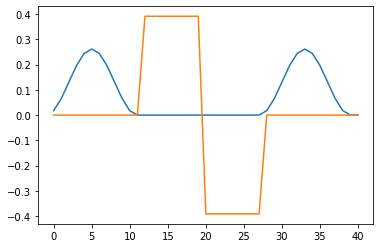

In [20]:
plt.plot(track1.full());
plt.plot(track2.full());

The third coefficient describing the exchange interactions will be time-independent. So in this case it is simplest to add a `constant` node.

In [21]:
track3 = iSWAP.constant(0.1988)

### Setting up a simulation with Op nodes

For this demonstration we will use the QuTip solver wrapped as a `solvequtip` op node.

The `solvequtip` op node takes as inputs a `ket` tensor node defining the initial state of the simulation a `time` tensor node defining the time samples used to output the simulation results and an arbitrary number of Hamiltonian terms encoded as `(operator,track)` pairs, in that order. Upon running the graph, the output of the `solvequtip` returns an array of kets evaluated at each time step (a rank 2 tensor).

The initial state for the simulation will be $|01\rangle$, expressed as a row vector (using `np.kron` to do the tensor product).

In [22]:
psi0 = iSWAP.ket(np.kron(zero,one))

We can create the `(operator,track)` pairs using join nodes.

In [23]:
op1 = iSWAP.join(h1,track1); op2 = iSWAP.join(h2,track2); op3 = iSWAP.join(h3,track3)

> *Reminder: these operations are not actually joining anything at this stage. It is just adding three new `join` nodes to the graph which have `operators` and `tracks` as input nodes. The process of performing the operations will only be done when `QuantumGraph.run()` is called.*

Now we can add the `solvequtip` op node to the graph.

In [24]:
psif = iSWAP.solvequtip(psi0,time,op1,op2,op3)

#### Expectation values

While we could just return these wavefunctions as the solution, it may be convenient to directly compute expectation values for certain observables. 

For that we define two projection operators, one for the initial state $|01\rangle$ and one for the desired target state $|10\rangle$ and add them as inputs to nodes which compute the expectation value of the time-dependent wavefunction given by the `solvequtip` node. Finally we use a `join` node to combine their outputs into one object for plotting.

In [25]:
P_01 = iSWAP.expectationvalue(psif,iSWAP.observable(O2(zero,one,zero,one)))

P_10 = iSWAP.expectationvalue(psif,iSWAP.observable(O2(one,zero,one,zero)))

output = iSWAP.join(P_01,P_10)

Thats it. Now we have completed our graph. Lets take a look at the list of nodes.

In [26]:
iSWAP.nodes

[<QG8 tensor node:operator, shape=(16, 16), length=8, itype=uint8, dtype=uint8>,
 <QG8 tensor node:operator, shape=(16, 16), length=8, itype=uint8, dtype=uint8>,
 <QG8 tensor node:operator, string_id='interaction', shape=(16, 16), length=1, itype=uint8, dtype=uint8>,
 <QG8 tensor node:time, shape=(41,), length=40, itype=uint8, dtype=uint8>,
 <QG8 tensor node:track, shape=(41,), length=24, itype=uint8, dtype=float32>,
 <QG8 tensor node:track, shape=(41,), length=16, itype=uint8, dtype=float32>,
 <QG8 tensor node:constant, shape=(1,), length=1, itype=uint8, dtype=float64>,
 <QG8 tensor node:ket, shape=(16, 1), length=1, itype=uint8, dtype=uint8>,
 <QG8 op node:join>,
 <QG8 op node:join>,
 <QG8 op node:join>,
 <QG8 op node:solvequtip>,
 <QG8 tensor node:observable, shape=(16, 16), length=1, itype=uint8, dtype=uint8>,
 <QG8 op node:expectationvalue>,
 <QG8 tensor node:observable, shape=(16, 16), length=1, itype=uint8, dtype=uint8>,
 <QG8 op node:expectationvalue>,
 <QG8 op node:join>]

Finally we must build the adjacency matrix which describes the connections between nodes and add it to the graph.

In [27]:
A = iSWAP.adjacency_matrix()

### Write the graph to a QG8 file

In [28]:
qg8.save("iSWAP.qg8", iSWAP);

The resulting file is a bit under 1kB in size.

In [29]:
iSWAP.datasize()  # datasize in bytes

914

### Read in the graph

In [30]:
savedgate = qg8.load("iSWAP.qg8")
savedgate.nodes

[<QG8 tensor node:operator, shape=(16, 16), length=8, itype=uint8, dtype=uint8>,
 <QG8 tensor node:operator, shape=(16, 16), length=8, itype=uint8, dtype=uint8>,
 <QG8 tensor node:operator, string_id='interaction', shape=(16, 16), length=1, itype=uint8, dtype=uint8>,
 <QG8 tensor node:time, shape=(41,), length=40, itype=uint8, dtype=uint8>,
 <QG8 tensor node:track, shape=(41,), length=24, itype=uint8, dtype=float32>,
 <QG8 tensor node:track, shape=(41,), length=16, itype=uint8, dtype=float32>,
 <QG8 tensor node:constant, shape=(1,), length=1, itype=uint8, dtype=float64>,
 <QG8 tensor node:ket, shape=(16, 1), length=1, itype=uint8, dtype=uint8>,
 <QG8 op node:join>,
 <QG8 op node:join>,
 <QG8 op node:join>,
 <QG8 op node:solvequtip>,
 <QG8 tensor node:observable, shape=(16, 16), length=1, itype=uint8, dtype=uint8>,
 <QG8 op node:expectationvalue>,
 <QG8 tensor node:observable, shape=(16, 16), length=1, itype=uint8, dtype=uint8>,
 <QG8 op node:expectationvalue>,
 <QG8 op node:join>]

### Simulate the graph

In [31]:
result = qg8.run(savedgate)

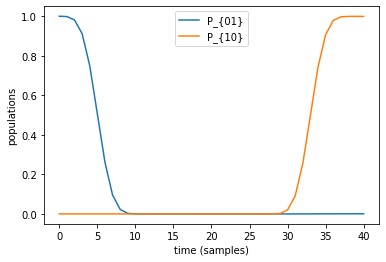

In [32]:
plt.plot(result[0],label=r'P_{01}');
plt.plot(result[1],label=r'P_{10}');
plt.ylabel("populations")
plt.xlabel("time (samples)")
plt.legend();

This shows that starting from the $|01\rangle$ state the system evolves to the $|10\rangle$ state, thereby realizing a swap operation. At intermediate times the system evolves through auxilliary two-qubit states involving the $|S\rangle$ and $|P\rangle$ states (region where $P_{01}$ and $P_{10}$ are approximately zero), but returns back to the computational subspace at the end of the protocol. 

We leave it as an exercise to confirm the full gate matrix for this protocol and to experiment with your own gate protocols or other quantum problems.